# Monotonicity

 A non increasing or non decreasing function is said to be monotonic i.e. when $\mathbf{x}<\mathbf{y}$ and $\mathbf{f(x)}<\mathbf{f(y)}$ (monotonically increasing) or when $\mathbf{x}<\mathbf{y}$ and $\mathbf{f(x)}>\mathbf{f(y)}$ (monotonically decreasing)

In [1]:
import warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import xgboost as xgb
import catboost as cb
import dalex as dx
from sklearn.experimental import (
    enable_hist_gradient_boosting,
)  # this is still experimental
import lightgbm as lgb
from typing import List

In [2]:
warnings.filterwarnings("ignore", category=FutureWarning)
# back to the default behavior
# warnings.filterwarnings("default", category=FutureWarning)

In [3]:
def target_df(x1: List, x2: List):
    """creates target using mathematically generated data
    (xgboost documentation)
    """
    target = []
    for x1, x2 in zip(x1, x2):
        target.append(
            (
                (5 * x1)
                + np.sin(10 * np.pi * x1)
                - (5 * x2)
                - np.cos(10 * np.pi * x2)
                + np.random.normal(0, 0.01)
            )
        )
    return target


def check_trend(model_profile: dx.Explainer.model_profile):
    """extract pdp values from dalex explainer object"""
    pdps = pd.DataFrame(model_profile.result)
    pdp_feats = [pdps[pdps["_vname_"] == i] for i in pdps["_vname_"].unique()]
    return pdp_feats


def plot_pdps(pdps: List, dfs_list: List, target: List):
    """utility to plot pdps extracted from dalex package"""
    rows = len(pdps)
    fig, axes = plt.subplots(nrows=rows, figsize=(12, 12))
    for p, d, ax in zip(pdps, dfs_list, axes):
        ax.scatter(d, target, facecolor="none", edgecolors="blue", alpha=0.4)
        ax.plot(p["_x_"], p["_yhat_"], color="k")

In [4]:
# Generating random 500 points between 0 and 1
x1 = [np.random.random() for i in range(500)]
x2 = [np.random.random() for i in range(500)]
target = pd.Series(target_df(x1, x2))

Text(0.5, 0, 'x2')

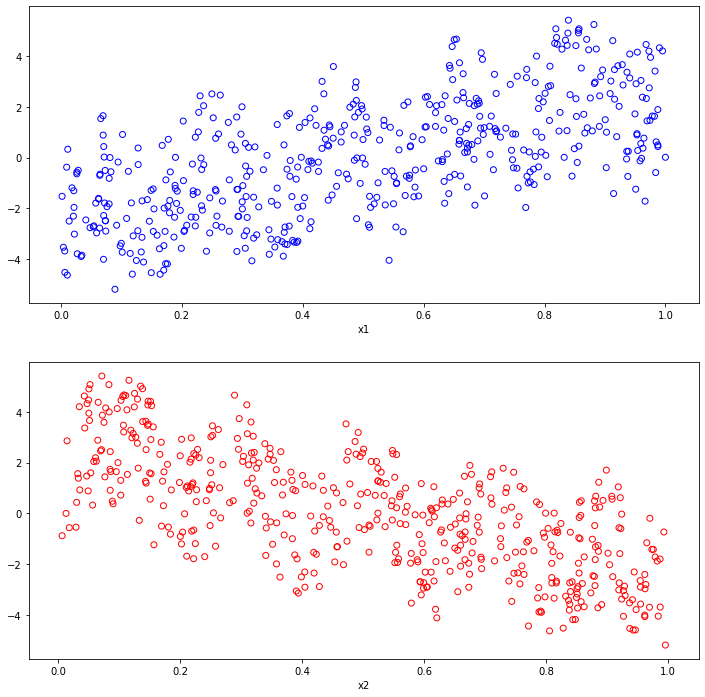

In [5]:
fig, (ax1, ax2) = plt.subplots(nrows=2, figsize=(12, 12))
ax1.scatter(x1, target, facecolor="none", edgecolors="blue")
ax1.set_xlabel("x1")

ax2.scatter(x2, target, facecolor="none", edgecolors="red")
ax2.set_xlabel("x2")

# XGBoost

In [6]:
pd_train = pd.DataFrame(pd.concat([pd.Series(x1), pd.Series(x2)], axis=1))
dtrain = xgb.DMatrix(pd_train, label=target)

params = {"max_depth": 2, "eta": 1, "objective": "reg:squarederror"}
params["nthread"] = 4
params["eval_metric"] = "rmse"

In [7]:
xgmod_noconst = xgb.train(params, dtrain, num_boost_round=1000)
exp_xg_noconst = dx.Explainer(xgmod_noconst, pd_train, target)

Preparation of a new explainer is initiated

  -> data              : 500 rows 2 cols
  -> target variable   : Parameter 'y' was a pandas.Series. Converted to a numpy.ndarray.
  -> target variable   : 500 values
  -> model_class       : xgboost.core.Booster (default)
  -> label             : Not specified, model's class short name will be used. (default)
  -> predict function  : <function yhat_xgboost at 0x7f9e79256280> will be used (default)
  -> predict function  : Accepts only pandas.DataFrame, numpy.ndarray causes problems.
  -> predicted values  : min = -5.2, mean = 0.0175, max = 5.42
  -> model type        : 'model_type' not provided and cannot be extracted.
  -> model type        : Some functionalities won't be available.
  -> residual function : difference between y and yhat (default)
  -> residuals         : min = -0.00732, mean = 8.55e-09, max = 0.00798
  -> model_info        : package xgboost

A new explainer has been created!


Calculating ceteris paribus: 100%|██████████| 2/2 [00:00<00:00,  2.67it/s]


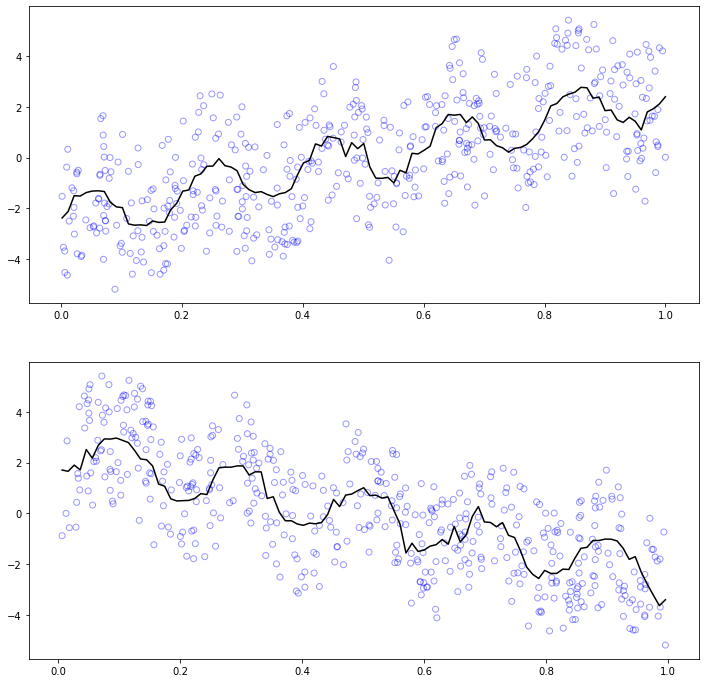

In [8]:
exp_xg_noconst_p = exp_xg_noconst.model_profile()
pdps_xg_noconst = check_trend(exp_xg_noconst_p)
plot_pdps(pdps_xg_noconst, [x1, x2], target)

In [9]:
xgparams_constrained = params.copy()
xgparams_constrained["monotone_constraints"] = "(1,-1)"

In [10]:
xgmod_with_const = xgb.train(xgparams_constrained, dtrain, num_boost_round=1000)

Preparation of a new explainer is initiated

  -> data              : 500 rows 2 cols
  -> target variable   : Parameter 'y' was a pandas.Series. Converted to a numpy.ndarray.
  -> target variable   : 500 values
  -> model_class       : xgboost.core.Booster (default)
  -> label             : Not specified, model's class short name will be used. (default)
  -> predict function  : <function yhat_xgboost at 0x7f9e79256280> will be used (default)
  -> predict function  : Accepts only pandas.DataFrame, numpy.ndarray causes problems.
  -> predicted values  : min = -5.69, mean = 0.0175, max = 5.07
  -> model type        : 'model_type' not provided and cannot be extracted.
  -> model type        : Some functionalities won't be available.
  -> residual function : difference between y and yhat (default)
  -> residuals         : min = -2.85, mean = 1e-08, max = 2.68
  -> model_info        : package xgboost

A new explainer has been created!


Calculating ceteris paribus: 100%|██████████| 2/2 [00:00<00:00, 27.29it/s]


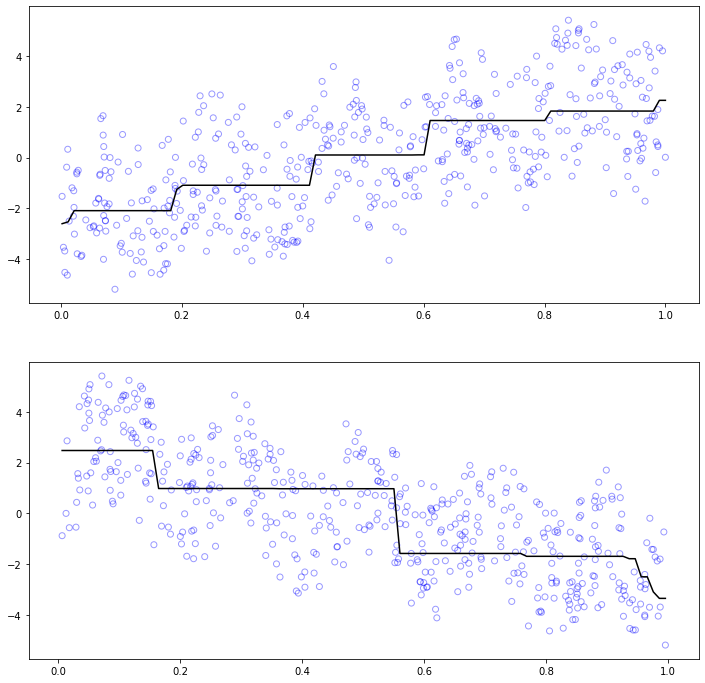

In [11]:
exp_xg_const = dx.Explainer(xgmod_with_const, pd_train, target)

exp_xg_const_p = exp_xg_const.model_profile()
pdps_xg_const = check_trend(exp_xg_const_p)
plot_pdps(pdps_xg_const, [x1, x2], target)

# Light GBM

In [12]:
lgb_train = lgb.Dataset(pd_train, target)

Preparation of a new explainer is initiated

  -> data              : 500 rows 2 cols
  -> target variable   : Parameter 'y' was a pandas.Series. Converted to a numpy.ndarray.
  -> target variable   : 500 values
  -> model_class       : lightgbm.basic.Booster (default)
  -> label             : Not specified, model's class short name will be used. (default)
  -> predict function  : <function yhat_default at 0x7f9e79256160> will be used (default)
  -> predict function  : Accepts pandas.DataFrame and numpy.ndarray.
  -> predicted values  : min = -5.1, mean = 0.0175, max = 5.46
  -> model type        : regression will be used (default)
  -> residual function : difference between y and yhat (default)
  -> residuals         : min = -0.43, mean = 6.86e-09, max = 0.373
  -> model_info        : package lightgbm

A new explainer has been created!


Calculating ceteris paribus: 100%|██████████| 2/2 [00:04<00:00,  2.16s/it]


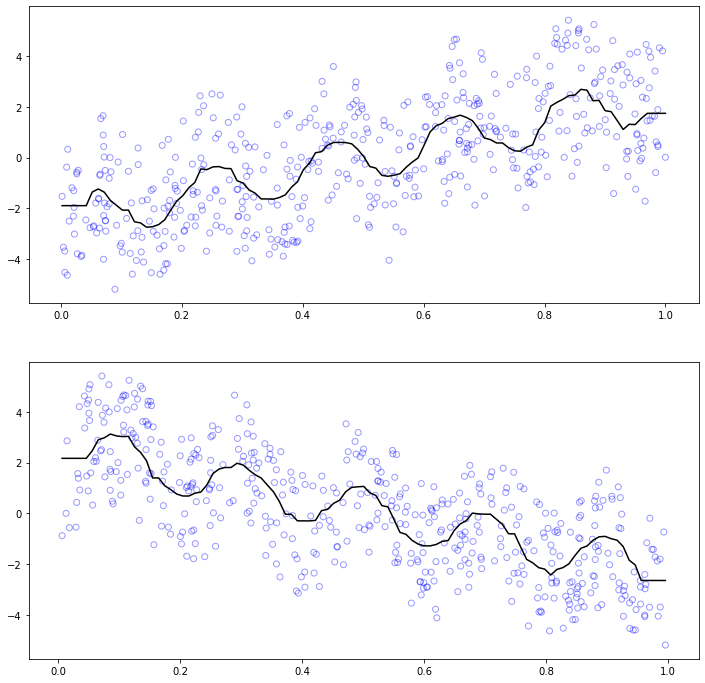

In [13]:
lgb_params = {
    "boosting_type": "gbdt",
    "objective": "regression",
    "verbose": -1,
}

lgbmod_noconst = lgb.train(lgb_params, lgb_train, num_boost_round=1000)
exp_lgb_noconst = dx.Explainer(lgbmod_noconst, pd_train, target)

exp_lgb_noconst_p = exp_lgb_noconst.model_profile()
pdps_lgb_noconst = check_trend(exp_lgb_noconst_p)
plot_pdps(pdps_lgb_noconst, [x1, x2], target)

In [14]:
lgb_params_constrained = lgb_params.copy()
lgb_params_constrained["monotone_constraints"] = [1, -1]

lgbmod_const = lgb.train(lgb_params_constrained, lgb_train, num_boost_round=1000)

Preparation of a new explainer is initiated

  -> data              : 500 rows 2 cols
  -> target variable   : Parameter 'y' was a pandas.Series. Converted to a numpy.ndarray.
  -> target variable   : 500 values
  -> model_class       : lightgbm.basic.Booster (default)
  -> label             : Not specified, model's class short name will be used. (default)
  -> predict function  : <function yhat_default at 0x7f9e79256160> will be used (default)
  -> predict function  : Accepts pandas.DataFrame and numpy.ndarray.
  -> predicted values  : min = -4.45, mean = 0.0175, max = 4.55
  -> model type        : regression will be used (default)
  -> residual function : difference between y and yhat (default)
  -> residuals         : min = -1.69, mean = 7.52e-09, max = 1.61
  -> model_info        : package lightgbm

A new explainer has been created!


Calculating ceteris paribus: 100%|██████████| 2/2 [00:00<00:00,  3.34it/s]


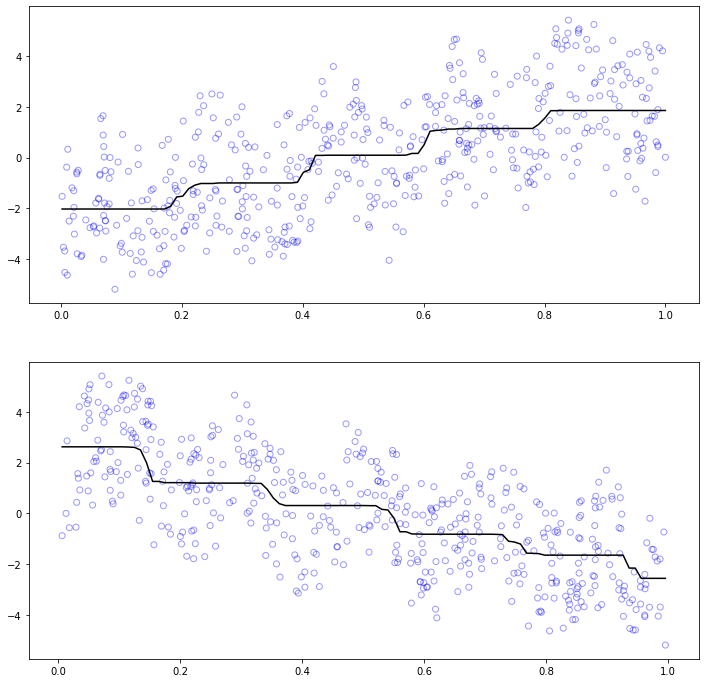

In [15]:
exp_lgb_const = dx.Explainer(lgbmod_const, pd_train, target)

exp_lgb_const_p = exp_lgb_const.model_profile()
pdps_lgb_const = check_trend(exp_lgb_const_p)
plot_pdps(pdps_lgb_const, [x1, x2], target)

 There are various other models/packages which allow us to enforce monotonicity, for e.g.

 * Splines [scipy](https://docs.scipy.org/doc/scipy/reference/generated/scipy.interpolate.PchipInterpolator.html), [stackoverflow answer based on R](https://stats.stackexchange.com/questions/197509/how-to-smooth-data-and-force-monotonicity)

 * Hist Gradient Boosting [scikit](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.HistGradientBoostingClassifier.html)

 * Catboost [(search for **monotone_constraints** upon clicking this)](https://catboost.ai/docs/concepts/python-reference_parameters-list.html)

 * TensorFlow Lattice [(TFL)](https://www.tensorflow.org/lattice/overview)